In [1]:
import numpy as np
from keras.datasets import mnist, fashion_mnist
import pandas as pd
from keras.layers import Input, Dense, concatenate 
from keras.models import Model, load_model
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm import tqdm
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras import objectives
from MulticoreTSNE import MulticoreTSNE as TSNEGPU
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# train_images = train_images.astype('float32') / 255.
# train_images = train_images.reshape((len(x_train), np.prod(train_images.shape[1:])))

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## the real DeepReduc

In [4]:
itd = 10

input_bottleneck = Input(shape=(itd,), name="inp_bt")
input_img = Input(shape=(784,), name="inp_img")
input_S = Input(shape=(itd,), name="inp_S")

encoded = Dense(256, activation='relu')(input_img)

bottlenek = Dense(itd, activation='relu', name="bottleneck")(encoded)

decoded = Dense(256, activation='relu')(bottlenek)
output = Dense(784, activation='sigmoid', name="logits")(decoded)


final_dense = concatenate(
    [input_bottleneck, 
     output,
     input_S
    ], name="concatenate")

model = Model([input_bottleneck, input_img, input_S], [final_dense, output])
#model.load_weights("dae2_lle.h5")

bottleneck_model = Model(inputs=model.get_layer("inp_img").input, outputs=model.get_layer("bottleneck").output)

#model = Model(input_img, output)

In [5]:
l = 2
def custom_loss(y_true, y_pred):
    bottle=y_pred[:,:itd]
    pred = y_pred[:,itd:784+itd]
    Sb = y_pred[:,784+itd:]
    
#     return tf.norm(y_true - pred) + l*tf.norm(bottle - Sb)
#     return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(y_true, pred))))
#     return K.sqrt(K.sum(K.square(y_true - pred))) 
#     return objectives.binary_crossentropy(y_true, pred) + l*objectives.binary_crossentropy(bottle, Sb)
    return K.sqrt(K.sum(K.square(y_true - pred), axis=-1)) + l*K.sqrt(K.sum(K.square(bottle - Sb), axis=-1))

model.compile(optimizer='adam', loss={"concatenate":custom_loss, "logits": None})

In [6]:
sub_train = [x_train[x:x+100] for x in range(0, len(x_train), 100)]

In [41]:
for epoch in range(0,30):
    for x in sub_train:
        bottleneck = bottleneck_model.predict(x)
        lle = LLEC(n_components=2, n_neighbors=10)
        S = lle.fit_W(bottleneck)
        sdotB = np.dot(S, bottleneck)
        lss = model.train_on_batch(
            [
                 bottleneck, 
                 x,
                 sdotB
            ], 
                x
        )
    print("epoch : ", epoch, " : ",lss)

epoch :  0  :  [5.1476507, 5.1476507]
epoch :  1  :  [5.132644, 5.132644]
epoch :  2  :  [5.139177, 5.139177]
epoch :  3  :  [5.121839, 5.121839]
epoch :  4  :  [5.126679, 5.126679]
epoch :  5  :  [5.108516, 5.108516]
epoch :  6  :  [5.1024027, 5.1024027]
epoch :  7  :  [5.094186, 5.094186]
epoch :  8  :  [5.066187, 5.066187]
epoch :  9  :  [5.0547786, 5.0547786]
epoch :  10  :  [5.0563903, 5.0563903]
epoch :  11  :  [5.0242467, 5.0242467]
epoch :  12  :  [5.037485, 5.037485]
epoch :  13  :  [5.0034046, 5.0034046]
epoch :  14  :  [5.0214205, 5.0214205]
epoch :  15  :  [4.9905434, 4.9905434]
epoch :  16  :  [4.9820194, 4.9820194]
epoch :  17  :  [4.9924536, 4.9924536]
epoch :  18  :  [4.985157, 4.985157]
epoch :  19  :  [4.9619184, 4.9619184]
epoch :  20  :  [4.9656234, 4.9656234]
epoch :  21  :  [4.96582, 4.96582]
epoch :  22  :  [4.963751, 4.963751]
epoch :  23  :  [4.975126, 4.975126]
epoch :  24  :  [4.95222, 4.95222]
epoch :  25  :  [4.9592075, 4.9592075]
epoch :  26  :  [4.9326787

In [37]:
# total epoch 100

### Reconstruction

#### Original 

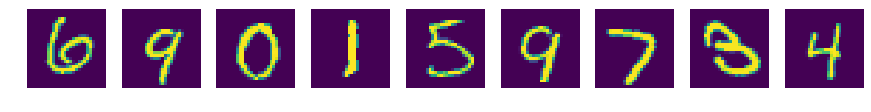

In [43]:
plt.figure(figsize=(15, 4))
for x in range(1,10):
    plt.subplot(1,9,x)
    plt.imshow(x_test[x].reshape(28,28))
    plt.axis('off')

plt.show()

In [ ]:
#### Reconstruct 

In [39]:
model_inference = Model(input_img, output)

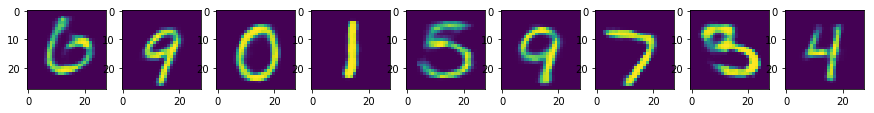

In [44]:
plt.figure(figsize=(15, 4))
for x in range(1,10):
    plt.subplot(1,9,x)
    plt.imshow(model_inference.predict(np.array([x_test[x]]))[0][0:784].reshape(28,28))
plt.show()

In [37]:
bt_train = bottleneck_model.predict(x_train, verbose=1)
pd.DataFrame(bt_train).to_csv("result/resultat/dae2_lle_2.csv", index=False)

60000/60000 [==============================] - 1s 18us/step


## A lot of test

#### Fashion Mnist 

In [114]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [16]:
model.load_weights("deepdr_mnist.h5")

In [17]:
bottleneck_model = Model(inputs=model.get_layer("inp_img").input, 
                         outputs=model.get_layer("bottleneck").output)

In [18]:
bt_train = bottleneck_model.predict(x_train, verbose=1)
pd.DataFrame(bt_train).to_csv("result_mnist/deepdr_mnist02.csv", index=False)

60000/60000 [==============================] - 1s 15us/step


#### Plot bottleneck

In [34]:
Y = bottleneck_model.predict(x_train, verbose=1)

60000/60000 [==============================] - 1s 14us/step


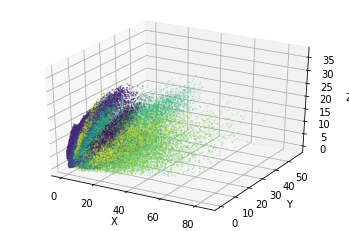

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( Y[:,0], Y[:,1], Y[:,2], c=list(y_train), s=0.1, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

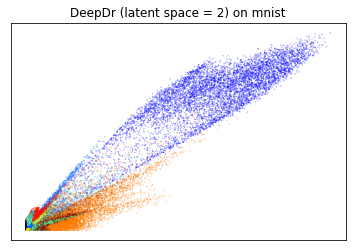

In [29]:
plt.scatter(Y[:,0], Y[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("DeepDr (latent space = 2) on mnist")
plt.xticks([])
plt.yticks([])
plt.show()

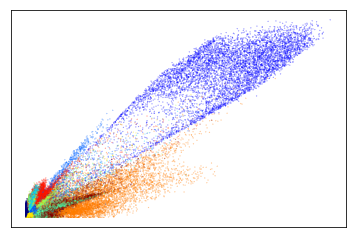

In [25]:
plt.scatter(Y[:,0], Y[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("DeepDr (latent space = 2)")
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
bt_train = bottleneck_model.predict(x_train, verbose=1)

60000/60000 [==============================] - 1s 15us/step


In [15]:
pd.DataFrame(bt_train).to_csv("resultat/dae2_lle.csv", index=False, header=False)

In [12]:
# model.save("02_10_10.h5")

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNEGPU

In [14]:
bt_train = bottleneck_model.predict(train_images, verbose=1)

60000/60000 [==============================] - 1s 15us/step


In [15]:
tsne = TSNEGPU(n_jobs=20, perplexity = 30)
Y3 = tsne.fit_transform(bt_train)

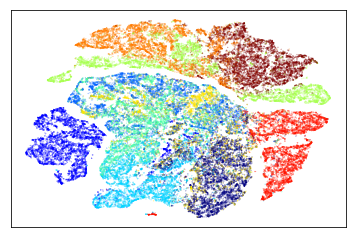

In [16]:
plt.scatter(Y3[:,0], Y3[:,1], c=list(train_labels), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
from sklearn import mixture

In [27]:
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(bt_train)

In [29]:
normalized_mutual_info_score(gmm.predict(bt_train),y_train)

/home/yannis/.local/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.00019534830217475297

In [20]:
tsne = TSNE(perplexity = 35)
Y4 = tsne.fit_transform(bt_train)

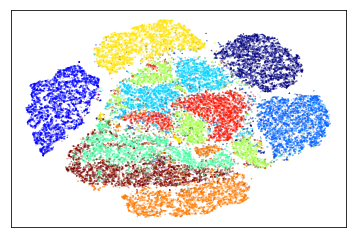

In [21]:
plt.scatter(Y4[:,0], Y4[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.xticks([])
plt.yticks([])
plt.show()

In [25]:
pd.DataFrame(bt_train).to_csv("resultat/normal/bottleneck.csv", index=False)

In [19]:
tsne = TSNE(perplexity = 35)
Y3 = tsne.fit_transform(bt_train)

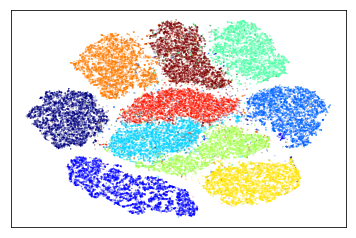

In [24]:
plt.scatter(Y3[:,0], Y3[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
bt_train = bottleneck_model.predict(x_train, verbose=1)
pd.DataFrame(bt_train).to_csv("bottleneck.csv", index=False)

60000/60000 [==============================] - 1s 16us/step


In [15]:
kmeans = KMeans(n_clusters=10).fit(bt_train)
print(adjusted_rand_score(y_train, kmeans.labels_))
print(normalized_mutual_info_score(y_train, kmeans.labels_))

0.3869471955761155
0.5162190487337579


/home/yannis/.local/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [19]:
pd.DataFrame(y_train).to_csv("labels.csv", index=False)

In [106]:
nmi = []
ari = []


    kmeans = KMeans(n_clusters=10).fit(bt_train)
    nmi.append(adjusted_rand_score(y_train, kmeans.labels_))
    ari.append(normalized_mutual_info_score(y_train, kmeans.labels_))

100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


In [107]:
#lambda 
print(np.mean(nmi))
print(np.mean(ari))

0.3869635190014705
0.5263558189054455


In [101]:
#lambda 
print(np.mean(nmi))
print(np.mean(ari))

0.38712280086076545
0.5260857110545196


In [83]:
pd.DataFrame(bt_train).to_csv("bottle_l1.csv", index=False)

In [78]:
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
#encoded = Dense(64, activation='relu')(encoded)

bottlenek = Dense(50, activation='relu', name="bottleneck")(encoded)

#decoded = Dense(64, activation='relu')(bottlenek)
decoded = Dense(256, activation='relu')(bottlenek)
output = Dense(784, activation='sigmoid', name="logits")(decoded)


autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [81]:
autoencoder.fit(x_train, x_train,epochs=20)

Epoch 1/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2689
Epoch 2/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.2688
Epoch 3/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.2687
Epoch 4/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2685
Epoch 5/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.2684
Epoch 6/20
60000/60000 [==============================] - 6s 106us/step - loss: 0.2683
Epoch 7/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.2682
Epoch 8/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.2681
Epoch 9/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.2680
Epoch 10/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2679
Epoch 11/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.2678
Epoch 12/20
60000/60000 [================

In [82]:
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

In [83]:
bt_train = bottleneck_model.predict(x_train, verbose=1)

60000/60000 [==============================] - 1s 16us/step


In [84]:
pd.DataFrame(bt_train).to_csv("result_fashion/bottle_ae_50.csv", index=False)

In [25]:
tsne = TSNEGPU(n_jobs=20, perplexity = 30)
Y5 = tsne.fit_transform(bt_train)

In [21]:
tsne = TSNEGPU(n_jobs=20, perplexity = 30)
Y4 = tsne.fit_transform(bt_train)

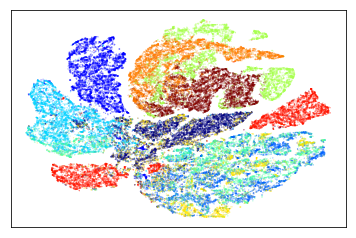

In [22]:
plt.scatter(Y4[:,0], Y4[:,1], c=list(train_labels), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.xticks([])
plt.yticks([])
plt.show()

In [133]:
# pd.DataFrame(bt_train).to_csv("bottle_classic2.csv", index=False)

In [203]:
kmeans = KMeans(n_clusters=10).fit(bt_train)
print(adjusted_rand_score(y_train, kmeans.labels_))
print(normalized_mutual_info_score(y_train, kmeans.labels_))

0.4075777160544746
0.529322418299357


/home/yannis/.local/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [205]:
K.clear_session()

In [49]:
model_pred = Model(input_img, output)

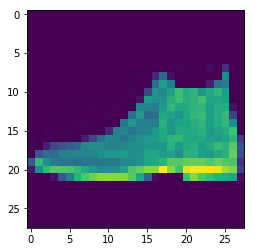

In [40]:
plt.imshow(x_test[0].reshape(28,28))
plt.show()

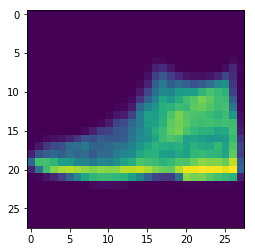

In [50]:
plt.imshow(model_pred.predict(x_test[0:1])[0].reshape(28,28))
plt.show()

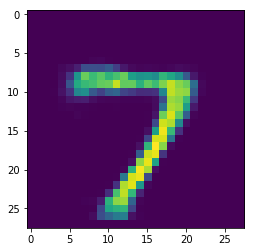

In [116]:
plt.imshow(autoencoder_test.predict(x_test[0:1])[0][0:784].reshape(28,28))
plt.show()

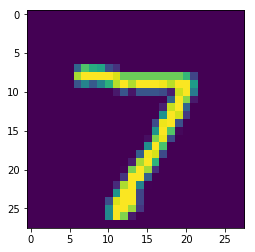

In [142]:
plt.imshow(x_test[0].reshape(28,28))
plt.show()

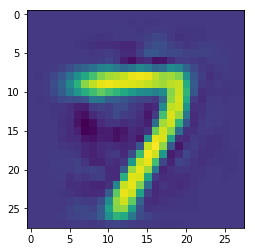

In [63]:
predt_model = Model(inputs=model.get_layer("inp_img").input, outputs=model.get_layer("logits").output)
plt.imshow(predt_model.predict(x_test[0:1])[0][0:784].reshape(28,28))
plt.show()

In [165]:
#plt.scatter(lle_X[:,0], lle_X[:,1])
#plt.show()

In [8]:
import numpy as np
from scipy.sparse import eye as speye
from scipy.sparse.csgraph import laplacian
from sklearn.manifold.locally_linear import (
    barycenter_kneighbors_graph, null_space, LocallyLinearEmbedding)
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from sklearn.neighbors import NearestNeighbors

from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh


class LLEC(LocallyLinearEmbedding):
    def __init__(self, n_neighbors=5, n_components=2, reg=1E-3,
                 eigen_solver='auto', tol=1E-6, max_iter=100,
                 method='standard', hessian_tol=1E-4, modified_tol=1E-12,
                 neighbors_algorithm='auto', random_state=None, n_jobs=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.reg = reg
        self.eigen_solver = eigen_solver
        self.tol = tol
        self.max_iter = max_iter
        self.method = method
        self.hessian_tol = hessian_tol
        self.modified_tol = modified_tol
        self.random_state = random_state
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    def fit_transform(self, X, y=None):
        self._fit_transform(X)
        return self.embedding_
    
    def fit_W(self, X):
        self._fit_transform(X)
        return self.W.toarray()
    
    def _fit_transform(self, X):
        self.nbrs_ = NearestNeighbors(self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs)

        random_state = self.random_state
        self.nbrs_.fit(X)
        self.W = \
            locally_linear_embedding(
                self.nbrs_, self.n_neighbors, self.n_components,
                eigen_solver=self.eigen_solver, tol=self.tol,
                max_iter=self.max_iter, method=self.method,
                hessian_tol=self.hessian_tol, modified_tol=self.modified_tol,
                random_state=random_state, reg=self.reg, n_jobs=self.n_jobs)

def locally_linear_embedding(
        X, n_neighbors, n_components, reg=1e-3, eigen_solver='auto', tol=1e-6,
        max_iter=100, method='standard', hessian_tol=1E-4, modified_tol=1E-12,
        random_state=None, n_jobs=None):
    
    if eigen_solver not in ('auto', 'arpack', 'dense'):
        raise ValueError("unrecognized eigen_solver '%s'" % eigen_solver)

    if method not in ('standard', 'hessian', 'modified', 'ltsa'):
        raise ValueError("unrecognized method '%s'" % method)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs)
    nbrs.fit(X)
    X = nbrs._fit_X

    N, d_in = X.shape

    if n_components > d_in:
        raise ValueError("output dimension must be less than or equal "
                         "to input dimension")
    if n_neighbors >= N:
        raise ValueError(
            "Expected n_neighbors <= n_samples, "
            " but n_samples = %d, n_neighbors = %d" %
            (N, n_neighbors)
        )

    if n_neighbors <= 0:
        raise ValueError("n_neighbors must be positive")

    M_sparse = (eigen_solver != 'dense')

    if method == 'standard':
        W = barycenter_kneighbors_graph(nbrs, n_neighbors=n_neighbors, reg=reg, n_jobs=1)

    
        if M_sparse:
            M = eye(*W.shape, format=W.format) - W
            M = (M.T * M).tocsr()
        else:
            M = (W.T * W - W.T - W).toarray()
            M.flat[::M.shape[0] + 1] += 1  # W = W - I = W - I

    elif method == 'hessian':
        dp = n_components * (n_components + 1) // 2

        if n_neighbors <= n_components + dp:
            raise ValueError("for method='hessian', n_neighbors must be "
                             "greater than "
                             "[n_components * (n_components + 3) / 2]")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        Yi = np.empty((n_neighbors, 1 + n_components + dp), dtype=np.float64)
        Yi[:, 0] = 1

        M = np.zeros((N, N), dtype=np.float64)

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Gi = X[neighbors[i]]
            Gi -= Gi.mean(0)

            # build Hessian estimator
            if use_svd:
                U = svd(Gi, full_matrices=0)[0]
            else:
                Ci = np.dot(Gi, Gi.T)
                U = eigh(Ci)[1][:, ::-1]

            Yi[:, 1:1 + n_components] = U[:, :n_components]

            j = 1 + n_components
            for k in range(n_components):
                Yi[:, j:j + n_components - k] = (U[:, k:k + 1] *
                                                 U[:, k:n_components])
                j += n_components - k

            Q, R = qr(Yi)

            w = Q[:, n_components + 1:]
            S = w.sum(0)

            S[np.where(abs(S) < hessian_tol)] = 1
            w /= S

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(w, w.T)

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'modified':
        if n_neighbors < n_components:
            raise ValueError("modified LLE requires "
                             "n_neighbors >= n_components")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        # find the eigenvectors and eigenvalues of each local covariance
        # matrix. We want V[i] to be a [n_neighbors x n_neighbors] matrix,
        # where the columns are eigenvectors
        V = np.zeros((N, n_neighbors, n_neighbors))
        nev = min(d_in, n_neighbors)
        evals = np.zeros([N, nev])

        # choose the most efficient way to find the eigenvectors
        use_svd = (n_neighbors > d_in)

        if use_svd:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                V[i], evals[i], _ = svd(X_nbrs,
                                        full_matrices=True)
            evals **= 2
        else:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                C_nbrs = np.dot(X_nbrs, X_nbrs.T)
                evi, vi = eigh(C_nbrs)
                evals[i] = evi[::-1]
                V[i] = vi[:, ::-1]

        # find regularized weights: this is like normal LLE.
        # because we've already computed the SVD of each covariance matrix,
        # it's faster to use this rather than np.linalg.solve
        reg = 1E-3 * evals.sum(1)

        tmp = np.dot(V.transpose(0, 2, 1), np.ones(n_neighbors))
        tmp[:, :nev] /= evals + reg[:, None]
        tmp[:, nev:] /= reg[:, None]

        w_reg = np.zeros((N, n_neighbors))
        for i in range(N):
            w_reg[i] = np.dot(V[i], tmp[i])
        w_reg /= w_reg.sum(1)[:, None]

        # calculate eta: the median of the ratio of small to large eigenvalues
        # across the points.  This is used to determine s_i, below
        rho = evals[:, n_components:].sum(1) / evals[:, :n_components].sum(1)
        eta = np.median(rho)

        # find s_i, the size of the "almost null space" for each point:
        # this is the size of the largest set of eigenvalues
        # such that Sum[v; v in set]/Sum[v; v not in set] < eta
        s_range = np.zeros(N, dtype=int)
        evals_cumsum = stable_cumsum(evals, 1)
        eta_range = evals_cumsum[:, -1:] / evals_cumsum[:, :-1] - 1
        for i in range(N):
            s_range[i] = np.searchsorted(eta_range[i, ::-1], eta)
        s_range += n_neighbors - nev  # number of zero eigenvalues

        # Now calculate M.
        # This is the [N x N] matrix whose null space is the desired embedding
        M = np.zeros((N, N), dtype=np.float64)
        for i in range(N):
            s_i = s_range[i]

            # select bottom s_i eigenvectors and calculate alpha
            Vi = V[i, :, n_neighbors - s_i:]
            alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)

            # compute Householder matrix which satisfies
            #  Hi*Vi.T*ones(n_neighbors) = alpha_i*ones(s)
            # using prescription from paper
            h = np.full(s_i, alpha_i) - np.dot(Vi.T, np.ones(n_neighbors))

            norm_h = np.linalg.norm(h)
            if norm_h < modified_tol:
                h *= 0
            else:
                h /= norm_h

            # Householder matrix is
            #  >> Hi = np.identity(s_i) - 2*np.outer(h,h)
            # Then the weight matrix is
            #  >> Wi = np.dot(Vi,Hi) + (1-alpha_i) * w_reg[i,:,None]
            # We do this much more efficiently:
            Wi = (Vi - 2 * np.outer(np.dot(Vi, h), h) +
                  (1 - alpha_i) * w_reg[i, :, None])

            # Update M as follows:
            # >> W_hat = np.zeros( (N,s_i) )
            # >> W_hat[neighbors[i],:] = Wi
            # >> W_hat[i] -= 1
            # >> M += np.dot(W_hat,W_hat.T)
            # We can do this much more efficiently:
            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(Wi, Wi.T)
            Wi_sum1 = Wi.sum(1)
            M[i, neighbors[i]] -= Wi_sum1
            M[neighbors[i], i] -= Wi_sum1
            M[i, i] += s_i

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'ltsa':
        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        M = np.zeros((N, N))

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Xi = X[neighbors[i]]
            Xi -= Xi.mean(0)

            # compute n_components largest eigenvalues of Xi * Xi^T
            if use_svd:
                v = svd(Xi, full_matrices=True)[0]
            else:
                Ci = np.dot(Xi, Xi.T)
                v = eigh(Ci)[1][:, ::-1]

            Gi = np.zeros((n_neighbors, n_components + 1))
            Gi[:, 1:] = v[:, :n_components]
            Gi[:, 0] = 1. / np.sqrt(n_neighbors)

            GiGiT = np.dot(Gi, Gi.T)

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] -= GiGiT
            M[neighbors[i], neighbors[i]] += 1
    
    return W
    a,b = null_space(M, n_components, k_skip=1, eigen_solver=eigen_solver,
                      tol=tol, max_iter=max_iter, random_state=random_state)
    
    #return a,b,W

### Resultat

In [46]:
result = glob.glob("result/*/*.txt")

In [ ]:
for s in scores:
        ax.scatter(score[0], score[2], label=nm)
        
        
ax.legend(loc=0, bbox_to_anchor=(1.40,1))
ax.set_title("Ratio ROC / PR")
ax.set_ylabel("PR AUC")
ax.set_xlabel("ROC AUC")
ax.grid(True)

In [128]:
mrk = {
    "0.2": "x",
    "0.5": ".",
    "0.8": "h",
    "1.0" : "+",
    "2.0" : "s"
}
color = {
    "3": "red",
    "5": "blue",
    "9": "green",
    "13" : "pink",
    "15" : "black"
}

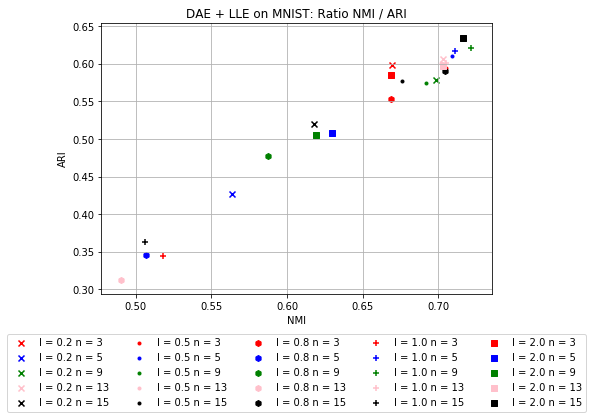

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
for r in values:
    lmb = r[0]
    ng = r[1]
    name = r[2]
    label = "l = "+str(lmb)+" n = "+str(ng)

    nmi = r[3]
    ari = r[4]
    
    ax.scatter(nmi, ari, label=label, marker=mrk[str(lmb)], c=color[str(ng)])

ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.45), ncol=5)
ax.set_title("DAE + LLE on MNIST: Ratio NMI / ARI")
ax.set_ylabel("ARI")
ax.set_xlabel("NMI")
ax.grid(True)

In [81]:
values = []
for r in result:
    name = r.split("/")[1]
    lmb = name.split("_")[0][1:]
    ng = name.split("_")[1][1:]
    with open(r) as l:
        scores = l.readlines()
    nmi = float(scores[0][4:-2])
    ari = float(scores[1][4:-2])
    
    values.append((float(lmb), int(ng), name, nmi, ari))

In [82]:
values = sorted(values)

In [165]:
# values

### Visualisation T-SNE

In [173]:
bottle_best = pd.read_csv("result/l2_n15/bottlneck.csv")

In [174]:
X_embedded = TSNE(n_components=2).fit_transform(bottle_best)

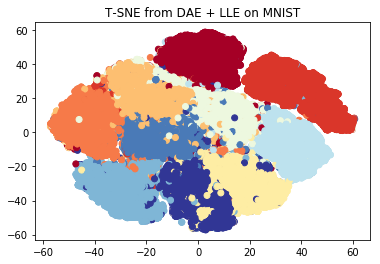

In [190]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_train, cmap=plt.cm.RdYlBu)
plt.title("T-SNE from DAE + LLE on MNIST")
# plt.xticks([])
# plt.yticks([])
plt.show()

In [161]:
bottle_best2 = pd.read_csv("result/l1_n9/bottlneck.csv")

In [162]:
tsn = TSNE(n_components=2)
X_embedded = tsn.fit_transform(bottle_best2)

In [164]:
# plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_train)
# plt.title("T-SNE MNIST")
# plt.show()

### Visualisation NMF

In [166]:
from sklearn.decomposition import NMF

In [169]:
model = NMF(n_components=10, init='nndsvdar', random_state=0)
W = model.fit_transform(x_train)
H = model.components_

In [171]:
tsn = TSNE(n_components=2)
X_embedded_nmf = tsn.fit_transform(W)

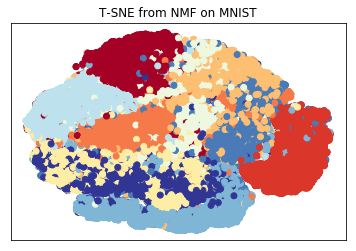

In [192]:
plt.scatter(X_embedded_nmf[:,0], X_embedded_nmf[:,1], c=y_train, cmap=plt.cm.RdYlBu)
plt.title("T-SNE from NMF on MNIST")
plt.xticks([])
plt.yticks([])
plt.show()